In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import lmfit
from IPython.display import Math

def TC(x, ystress=1.0, eta_bg=0.1, gammadot_crit=0.1):
    """Three component model
    Note:
    .. math::
       \sigma=\sigma_y+\sigma_y\cdot(\dot\gamma/\dot\gamma_c)^{0.5}+\eta_{bg}\cdot\dot\gamma
    Args:
        ystress: yield stress [Pa]
        eta_bg : Background viscosity [Pa s]
        gammadot_crit : Critical shear rate [1/s]
    Returns:
        stress : Shear Stress, [Pa]
    """
    return ystress + ystress * (x / gammadot_crit) ** 0.5 + eta_bg * x


# instantiate model class
TC_model = lmfit.Model(TC, prefix="TC_")
""" Lmfit model from equation :meth:`rheofit.models.TC`
Note:
TC_model.set_param_hint('ystress', min=0)
TC_model.set_param_hint('eta_bg', min=0, vary=True)
TC_model.set_param_hint('gammadot_crit', min=0)
"""
TC_model.model_expression = Math(
    "\sigma=\sigma_y+\sigma_y\cdot(\dot\gamma/\dot\gamma_c)^{0.5}+\eta_{bg}\cdot\dot\gamma"
)

def HB(x, ystress=1.0, K=1.0, n=0.5):
    """Hershel-Bulkley Model
    Note:
    .. math::
       \sigma= \sigma_y + K \cdot \dot\gamma^n
    Args:
        ystress: yield stress [Pa]
        K : Consistency index [Pa s^n]
        n : Shear thinning index []
    Returns:
        stress : Shear Stress, [Pa]
    """
    return ystress + K * x ** n


HB_model = lmfit.Model(HB, prefix="HB_")
""" Lmfit model from equation :meth:`rheofit.models.HB`
Note:
HB_model.set_param_hint('ystress', min=0)
HB_model.set_param_hint('K', min=0, vary=True)
HB_model.set_param_hint('n', min=0.0,max=1,vary=True)
"""

HB_model.model_expression = Math("\sigma=\sigma_y+K\cdot\dot\gamma^n")

HB_model.set_param_hint("ystress", min=0)
HB_model.set_param_hint("K", min=0, vary=True)
HB_model.set_param_hint("n", min=0.0, max=1, vary=True)



In [101]:
data_fig_6=pd.read_csv('figure_6.csv', header=[0,1])
data_fig_9=pd.read_csv('figure_9.csv', header=[0,1])

In [104]:
sample_label_list_fig6=list(data_fig_6.columns.get_level_values(0).unique())
sample_label_list_fig9=list(data_fig_9.columns.get_level_values(0).unique())


Text(0.5, 0.98, 'Fig6-Fig9 data from 10.1039/d0sm01196g')

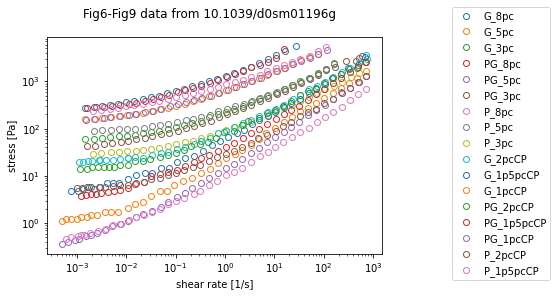

In [119]:
fig, ax = plt.subplots()

for sample_label in sample_label_list_fig6:
    data=data_fig_6.loc[:,data_fig_6.columns.get_level_values(0)==sample_label][sample_label]
    ax.plot(data['X'],data['Y'], marker='o', linestyle= 'None', mfc='None', label=sample_label)
    ax.set_yscale('log')
    ax.set_xscale('log')

for sample_label in sample_label_list_fig9:
    data=data_fig_9.loc[:,data_fig_9.columns.get_level_values(0)==sample_label][sample_label]
    ax.plot(data['X'],data['Y'], marker='o', linestyle= 'None', mfc='None', label=sample_label)
    ax.set_yscale('log')
    ax.set_xscale('log')

ax.set_xlabel('shear rate [1/s]')
ax.set_ylabel('stress [Pa]')
fig.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig.suptitle('Fig6-Fig9 data from 10.1039/d0sm01196g')

Text(0.5, 0.98, 'Fig6-Fig9 data from 10.1039/d0sm01196g')

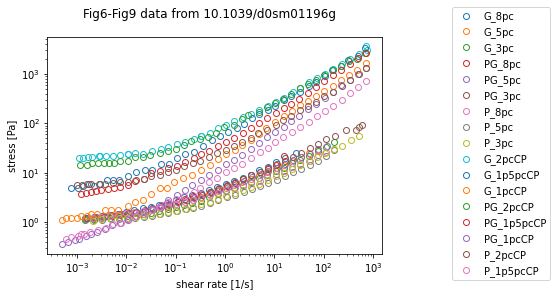

In [127]:
fig, ax = plt.subplots()

for sample_label in sample_label_list_fig6:
    data=data_fig_6.loc[:,data_fig_6.columns.get_level_values(0)==sample_label][sample_label]
    fit=HB_model.fit(data['Y'],x=data['X'],weights=1/data['Y'], nan_policy='omit')
    ax.plot(data['X'],data['Y']/fit.best_values['HB_ystress'], marker='o', linestyle= 'None', mfc='None', label=sample_label)
    ax.set_yscale('log')
    ax.set_xscale('log')

for sample_label in sample_label_list_fig9:
    data=data_fig_9.loc[:,data_fig_9.columns.get_level_values(0)==sample_label][sample_label]
    fit=HB_model.fit(data['Y'],x=data['X'],weights=1/data['Y'], nan_policy='omit')
    ax.plot(data['X'],data['Y']/fit.best_values['HB_ystress'], marker='o', linestyle= 'None', mfc='None', label=sample_label)
    ax.set_yscale('log')
    ax.set_xscale('log')

ax.set_xlabel('shear rate [1/s]')
ax.set_ylabel('stress [Pa]')
fig.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig.suptitle('Fig6-Fig9 data from 10.1039/d0sm01196g')

In [126]:
fit.best_values['HB_ystress']


27.326766380457148